Binôme: Reda Chaguer, Sohaib Errabii

# IF240 - Apprentissage et deep learning

## Practice 2: Naive Bayes, Evaluation Metrics, SVM 

By Aurélie Bugeau
Credits:  Vincent Lepetit, Varun Kumar, Mohit Deshpande

### Objectives 
The objective of the practice is to clssifiy emails from a dataset as spam or non-spam. 
You will compare diffrent classification methods: Naive Bayes and SVM, ansd implement several validation metrics

### Libraries
The code needs to import the following libraries

In [169]:
import pandas as pd
import numpy as np
import math
import re
import string

## 1 Dataset

#### Presentation and Loading
The dataset used here contained 747 spam and 4825 non-spam (i.e. ham) mails. 
Emails in the corpus have been already pre-processed in the following ways:
Removal of stop words (and, the, of, etc) and lemmatization (inludes, included, include are now all considered as include)

In [170]:
#Open the dataset
mails = pd.read_csv("spamham.csv")
#count the number of spam/ham mails
count = mails['Category'].value_counts()
print(count)
print(mails.head(), '\n')

ham     4825
spam     747
Name: Category, dtype: int64
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro... 



#### Training and evaluation sets
Split the dataset into training and evaluation sets.

In [171]:
# split data as train and evaluation sets. 
msk = np.random.rand(len(mails)) < 0.8
training_set = mails[msk]
print("taille du training set: " + str(len(training_set)))
testing_set = mails[~msk];
print("taille du testing set: " + str(len(testing_set)))


taille du training set: 4389
taille du testing set: 1183


## 2 Naive Bayes Classification
The classifier must be able to predict the label based on the text by implementing the following pseudo code:

`
if (P('ham' | message ) > P( 'spam' | message )) {
  return ‘ham’;
} 
else {
  return ‘spam’;
}
`

where
$$ P(ham | message)~=~ {\rm Probability ~that~ email~ is ~ham~ given~ that~ it~ has~ certain~ features~} $$
The features can for instance be a set of given words.
$$ P(spam | message)~=~ {\rm Probability ~that~ email~ is ~spam~ given~ that~ it~ has~ certain~ features~} $$



### Question 1 

Apply the Naive Bayes formula in the following code to implement a classifier. You will consider that:
$$P(message | spam) = P(word1 | spam) * P(word2 | spam) *...$$

 
_Note:_ if a word in the testing dataset is not present in the training dataset, you may encounter problems as $P(new | ham)$ or $P(new | spam)$ will be 0 making all product equal to 0.
To solve this problem, we should take log on both sides. New pseudo code will be

`
if (log(P('ham' | message )) > log(P('spam' | message))) {
  return ‘ham’;
} else {
  return ‘spam’;
}
`

Then 
$$ log(P(message| spam)) =  log(P(word1 | spam)) + log(P(word2 | spam)) …$$

But the problem is still not solved. If the classifier encounters a new word that is not present in our training data sets then P(new-word | category) will be 0 and log(0) is undefined. To solve this problem, you must use Laplace smoothing:

$$P(word1 | spam) = \frac{{\rm number~ of ~}word1 {\rm~belonging~ to ~category~ spam + 1}}{{\rm  number ~ of ~words~ belonging~ to ~spam ~}+{ \rm ~number ~of~ distinct ~words~ in ~training ~datasets~}}$$


In [172]:

#tokenize a string into words    
def tokenize(text):
    return re.split("\W+", str(text))
    
class SpamDetectorNB(object):
    
    def __init__(self):
        self.numberOfmessages = {} 
        self.log_class_priors = {}
        self.word_counts = {}
        self.word_index = {}
        self.vocab = set()
    

    # compute log class priors log(𝑃(ℎ𝑎𝑚)) and log(𝑃(sp𝑎𝑚))  
    #by counting up how many spam/ham messages are in our dataset and dividing by the total number
    def log_priors(self, training_set):
        nb_ham = training_set['Category'].value_counts()['ham']
        nb_spam = training_set['Category'].value_counts()['spam']
        self.log_class_priors['spam'] = np.log(nb_spam / nb_ham + nb_spam)
        self.log_class_priors['ham'] = np.log(nb_ham / nb_ham + nb_spam)
             
    #Count how many times each word appears in a text. 
    #Returns a dictionary that contain for each word indicates the number of times it appears in text. 
    def get_word_counts(self, text):
        word_counts = {}
        for w in tokenize(text):
            word_counts[w] = word_counts.get(w, 0) + 1
        #You can use the Python dictionary method get()
        return word_counts
    
    #Create a dictionary (a vocabulary of words)
    #and count words frequency for spam and ham separately
    def get_word_frequency(self, training_set):
        self.word_counts['spam'] = {}
        self.word_counts['ham'] = {}
        for _, mail in training_set.iterrows():
            label = mail['Category']
            text = mail['Message']
            #Tokenize each message into words.
            counts = self.get_word_counts(tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.word_index[word] = len(self.vocab)
                    self.vocab.add(word)
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0.0
                self.word_counts[label][word] += count
                
                
    #compute all necessary features
    def train(self, training_set):
        self.log_priors(training_set)
        self.get_word_frequency(training_set)
        
        
    def predict(self, testing_set):
        result = []
        for _, mail in testing_set.iterrows():
            label = mail['Category']
            text = mail['Message']
            
            #Tokenize each message into words.
            counts = self.get_word_counts(tokenize(text))
            
            #Initialize 𝑙𝑜𝑔(𝑃(spam|message)) and 𝑙𝑜𝑔(𝑃(ham|message))  according to log priors
            log_spam = self.log_class_priors['spam']
            log_ham = self.log_class_priors['ham']
            
            #For each message, compute 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) 
            for word, _ in counts.items():
                if word not in self.vocab: continue         
                #For each word compute log(P(w/spam)) and log(P(w/ham))
                occurrences_in_spam = self.word_counts['spam'].get(word, 0)
                log_w_spam = np.log(occurrences_in_spam + 1 / (len(self.word_counts['spam']) + len(self.vocab)))
                
                occurrences_in_ham = self.word_counts['ham'].get(word, 0)
                log_w_ham = np.log(occurrences_in_ham + 1 / (len(self.word_counts['ham']) + len(self.vocab)))
                
                #Update 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) 
                log_spam += log_w_spam
                log_ham += log_w_ham
                
                
            #decide spam or ham
            if(log_ham > log_spam):
                result.append([label, 'ham'])
            else:
                result.append([label, 'spam'])            

        return result             
    
sd = SpamDetectorNB()
sd.train(training_set)
result = sd.predict(testing_set)
print(result[:5])

[['spam', 'spam'], ['ham', 'ham'], ['ham', 'ham'], ['spam', 'spam'], ['ham', 'ham']]


### Question 2 - Accuracy and confution matrix
Compute the precision, recall, accuracy and confusion matrix

In [173]:
#value at index = 0 is actual label and index = 1 is predicted label
tp_spam = 0
fp_spam = 0

tp_ham = 0
fp_ham = 0
for i in range(len(result)):
    if result[i][0] == result[i][1]:
        if result[i][0] == 'spam':
            tp_spam += 1
        else:
            tp_ham += 1
    else:
        if result[i][1] == 'spam':
            fp_spam += 1
        else:
            fp_ham += 1

precision_spam = tp_spam / (tp_spam + fp_spam)
print("Precision for spam: {0:.4f}".format(precision_spam))
precision_ham = tp_ham / (tp_ham + fp_ham)
print("Precision for ham: {0:.4f}".format(precision_ham))

# false negatives of spam == false positives of ham and vice versa
recall_spam = tp_spam / (tp_spam + fp_ham)
print("Recall for spam: {0:.4f}".format(recall_spam))
recall_ham = tp_ham / (tp_ham + fp_spam)
print("Recall for ham: {0:.4f}".format(recall_ham))

# true negatives of spam == true positives of ham and vice versa
# accuracy of spam == accuracy of ham
accuracy = (tp_spam + tp_ham) / (tp_spam + tp_ham + fp_spam + fp_ham) 
print("Accuracy : {0:.4f}".format(accuracy))

print("\nConfusion matrix using SpamDetectorNB:")
confusion_mat = np.zeros((2, 2))
confusion_mat[0, 0] = tp_spam
confusion_mat[0, 1] = fp_ham # equal to false negatives of spam
confusion_mat[1, 0] = fp_spam
confusion_mat[1, 1] = tp_ham # equal to true negatives of spam

classes = ['spam', 'ham']
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print(confusion_df)

Precision for spam: 0.9851
Precision for ham: 0.9762
Recall for spam: 0.8408
Recall for ham: 0.9981
Accuracy : 0.9772

Confusion matrix using SpamDetectorNB:
       spam     ham
spam  132.0    25.0
ham     2.0  1024.0


### Question 3 - Naive Bayes with Scikit-learn library
The Scikit-learn library proposes many functions for machine learning.  Study the documentation of the  MultinomialNB function and apply it for spam detection.

You will need to convert the dataset into arrays


In [174]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# preprocessing
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(mails['Message']).toarray()
y = 1 - LabelEncoder().fit_transform(mails['Category']) # spam = 0 and ham = 1

# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# set up the MultinomialNB classifier and train it
classifierMNB = MultinomialNB()
classifierMNB.fit(x_train, y_train)

# prediction
y_pred = classifierMNB.predict(x_test)
y_pred[:20]

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

### Question 4 - Evaluation with Scikit-learn library
The Scikit-learn library also proposes  functions to evaluate machine learning methods. Apply them to the spam detection problem

Accuracy : 0.9806

Ou encore avec plus de détails:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       185
           1       0.99      0.99      0.99      1208

    accuracy                           0.98      1393
   macro avg       0.96      0.96      0.96      1393
weighted avg       0.98      0.98      0.98      1393

Confusion matrix using MultinomialNB:


<AxesSubplot:>

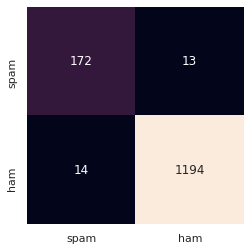

In [175]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy : {0:.4f}".format(accuracy))

print("\nOu encore avec plus de détails:")
print(classification_report(y_test, y_pred))

print("Confusion matrix using MultinomialNB:")
cmMNB = confusion_matrix(y_test, y_pred)
#for visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmMNB, square=True, annot=True, fmt='d', cbar=False, xticklabels = ['spam', 'ham']\
           ,yticklabels = ['spam', 'ham'])


### Question 5 - SVM Scikit-learn library
Apply SVM with a linear kernel to the spam dataset. 

Accuracy : 0.9842
Confusion matrix using LinearSVC:


<AxesSubplot:>

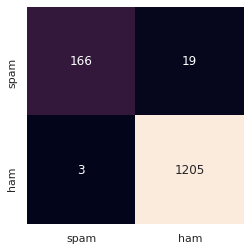

In [176]:
from sklearn.svm import LinearSVC

# train classifier
classifierLSVC = LinearSVC()
classifierLSVC.fit(x_train, y_train)

# prediction
y_pred = classifierLSVC.predict(x_test)
y_pred[:20]

# evaluation
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy : {0:.4f}".format(accuracy))

print("Confusion matrix using LinearSVC:")
cmMNB = confusion_matrix(y_test, y_pred)
#for visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmMNB, square=True, annot=True, fmt='d', cbar=False, xticklabels = ['spam', 'ham']\
           ,yticklabels = ['spam', 'ham'])